# Neural Networks to predict protein activation

### Improvement ideas
* Look at one hot key encoding, are we dropping one of the 21 features? do we need to do so?
* One vector with four 1s, we might be loosing information
* Class weights
* Number of epochs
* batch size
* Neural Network (number of layers, where to put drop out layer, activations)
* Optimizer, loss function for f1

#### Set up the directories, load libraries

In [0]:
import pandas as pd
import numpy as np

import pickle
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import keras
import keras.backend as K
from keras import Sequential

from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers import AlphaDropout

from keras.regularizers import l2

from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras import initializers

from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

In [69]:
tf.test.gpu_device_name()
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

['/device:GPU:0']

In [70]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4305498272016405935, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12834952334603684061
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13940999442782780143
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16685261985922353773
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
#!if [ ! -f Archive.zip ]; then wget -nv https://drive.google.com/open?id=1g7aT8cMkFAFlk6wxkiEH3mgFVp2Xa1l9 -O Archive.zip; fi

In [0]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount= True)
# import os
# os.chdir("/content/drive/My Drive/IML/IML_Projects/task_3")
# os.getcwd()

In [73]:
import os
os.getcwd()

'/content'

In [74]:
! ls

Data  model.h5	models	prediction.csv	sample_data


#### Load data & data inspection

In [0]:
dat_train = pd.read_csv("./Data/train.csv")
dat_test = pd.read_csv("./Data/test.csv")

In [76]:
# check class balance on activation
dat_train['Active'].value_counts()

0    107787
1      4213
Name: Active, dtype: int64

In [77]:
dat_train.iloc[np.where(dat_train['Active'] == 1)]

,Sequence,Active
77,IHGS,1
91,KSYG,1
102,LCLA,1
122,YYCV,1
164,VVGS,1
...,...,...
111823,YTCG,1
111850,VSGA,1
111875,FTGS,1
111879,LRLV,1


#### Pre-process data

In [0]:
import re

def split_convert(word_inp): 
    return [ord(i) for i in word_inp] 

In [0]:
train_seqs = [split_convert(i) for i in dat_train.iloc[:,0]]
train_labels = [i for i in dat_train.iloc[:,1]]
test_seqs = [split_convert(i) for i in dat_test.iloc[:,0]]

In [0]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
train_seqs_onehot = onehot_encoder.fit_transform(train_seqs)
test_seqs_onehot = onehot_encoder.transform(test_seqs)

#### Define Neural Network Architecture and Model

In [0]:
# functions to determine metrics f1, precision and recall
# taken from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def get_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [0]:
# determine class imbalance
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [0]:
# class_weight = {0:1, 1:12}
NEPOCHS = 200
BATCHSIZE = 180
VALIDATIONSPLIT = 0.2
HIDDENSIZE = 80
SEED = 42



In [0]:
os.environ['PYTHONHASHSEED']=str(SEED)

tf.random.set_seed(SEED)

from numpy.random import seed
seed(SEED)

In [0]:
# opt = SGD(lr=0.01, momentum=0.9)


opt = keras.optimizers.Adam(clipnorm = 10)
kernel_l2_regularizer = 2 * 1 * 1e-5
kernel_l1_regularizer = 0#1 * 1e-4
activity_l2_regularizer = 0#1 * 1e-5

HIDDENLAYER0 = 60
HIDDENLAYER1 = 60
HIDDENLAYER2 = 90
HIDDENLAYER3 = HIDDENLAYER1

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps= int(112000 * 0.9 / BATCHSIZE) * 1000,
  decay_rate=1,
  staircase=False)
opt = tf.keras.optimizers.Adam(lr_schedule)

def create_model():
  model = Sequential()
  model.add(Dense(HIDDENLAYER0, input_dim = 80, activation= None,
                  kernel_initializer= initializers.lecun_normal(seed=SEED),
                  kernel_regularizer=l2(kernel_l2_regularizer)))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
    
  model.add(Dense(HIDDENLAYER1, input_dim = HIDDENLAYER0, activation= None, 
                  kernel_initializer= initializers.lecun_normal(seed=SEED),
                  kernel_regularizer=l2(kernel_l2_regularizer)))
  model.add(Activation('relu'))


  # # model.add(AlphaDropout(rate = 0.5, seed = SEED))
  model.add(Dropout(rate = 0.5))
  model.add(BatchNormalization())

  model.add(Dense(1, input_dim = HIDDENLAYER1, activation='sigmoid',
                  kernel_initializer= initializers.lecun_normal(seed=SEED)))

  model.compile(optimizer=opt,
                loss="binary_crossentropy",
 #               loss='mean_squared_error',
                metrics=['accuracy', get_f1])

  return model


In [0]:
def plot_loss_f1(model):
  plt.plot(model.history['get_f1'])
  plt.plot(model.history['val_get_f1'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


#### Model Selection / training

In [0]:
kfold_splits = 10
folds = list(StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=SEED).split(train_seqs_onehot, train_labels))

In [88]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [89]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/device:GPU:0']

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 60)                4860      
_________________________________________________________________
activation_132 (Activation)  (None, 60)                0         
_________________________________________________________________
dense_196 (Dense)            (None, 60)                3660      
_________________________________________________________________
activation_133 (Activation)  (None, 60)                0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 60)                0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 60)                240       
_________________________________________________________________
dense_197 (Dense)            (None, 1)               

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Restoring model weights from the end of the best epoch
Epoch 00106: early stopping


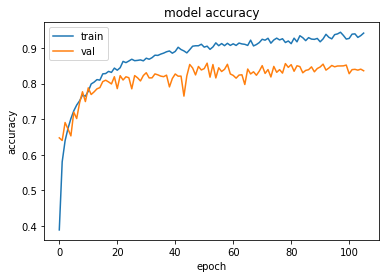

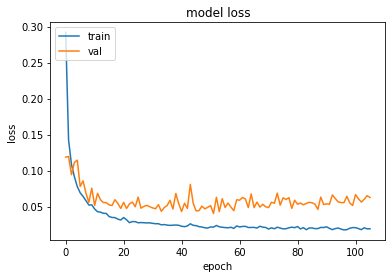

Number of positive predicted samples in the validation set:  484
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  484
F1 score for this fold is :  0.8729281767955801 0.9338425526672416
Training on fold 2/10...
Restoring model weights from the end of the best epoch
Epoch 00104: early stopping


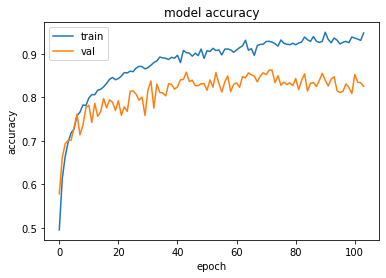

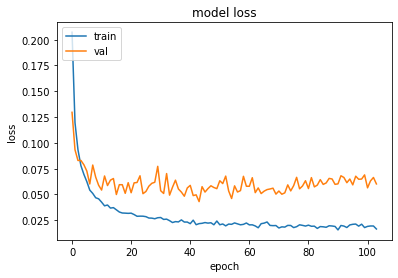

Number of positive predicted samples in the validation set:  466
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  466
F1 score for this fold is :  0.8771138669673055 0.9492671927846674
Training on fold 3/10...
Restoring model weights from the end of the best epoch
Epoch 00099: early stopping


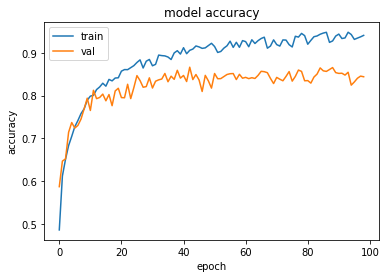

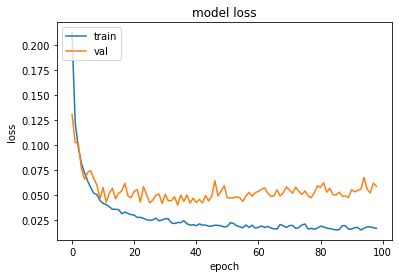

Number of positive predicted samples in the validation set:  490
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  490
F1 score for this fold is :  0.8781558726673984 0.9460808786819771
Training on fold 4/10...
Restoring model weights from the end of the best epoch
Epoch 00147: early stopping


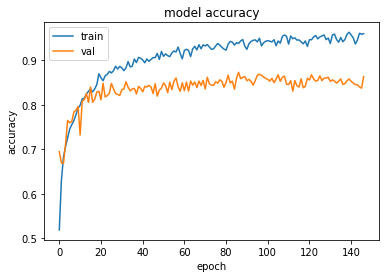

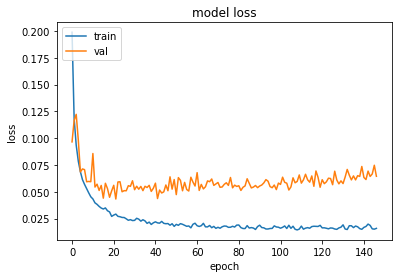

Number of positive predicted samples in the validation set:  471
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  471
F1 score for this fold is :  0.8766816143497758 0.9620606522014973
Training on fold 5/10...
Restoring model weights from the end of the best epoch
Epoch 00164: early stopping


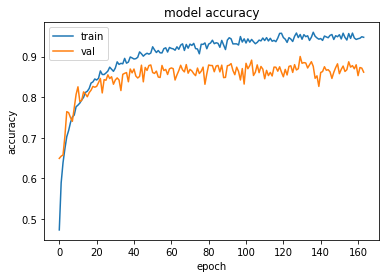

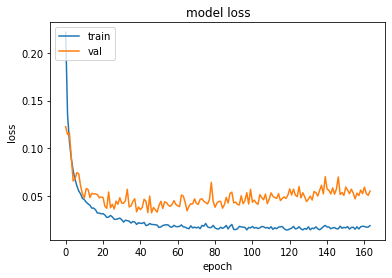

Number of positive predicted samples in the validation set:  454
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  454
F1 score for this fold is :  0.9005714285714287 0.9779326364692219
Training on fold 6/10...
Restoring model weights from the end of the best epoch
Epoch 00129: early stopping


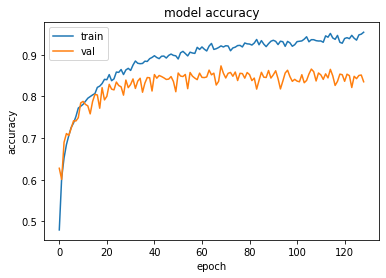

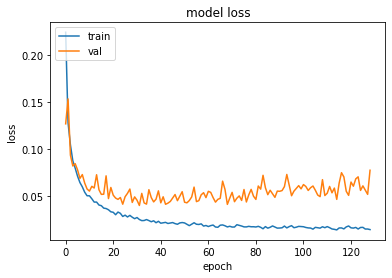

Number of positive predicted samples in the validation set:  467
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  467
F1 score for this fold is :  0.8806306306306306 0.9655963302752294
Training on fold 7/10...
Restoring model weights from the end of the best epoch
Epoch 00103: early stopping


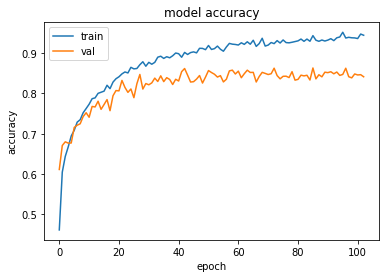

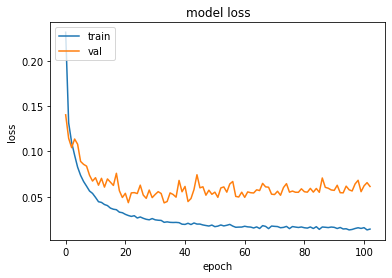

Number of positive predicted samples in the validation set:  496
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  496
F1 score for this fold is :  0.8636859323882224 0.9430489927878637
Training on fold 8/10...
Restoring model weights from the end of the best epoch
Epoch 00100: early stopping


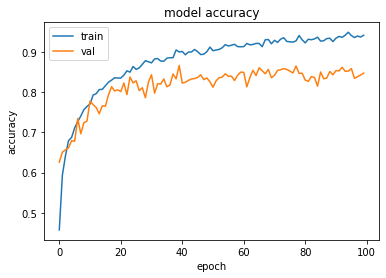

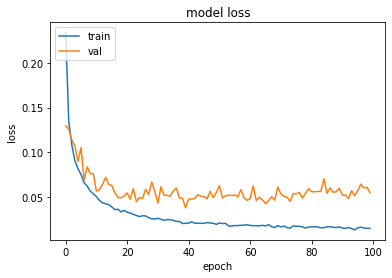

Number of positive predicted samples in the validation set:  482
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  482
F1 score for this fold is :  0.8805309734513272 0.9508155583437892
Training on fold 9/10...
Restoring model weights from the end of the best epoch
Epoch 00118: early stopping


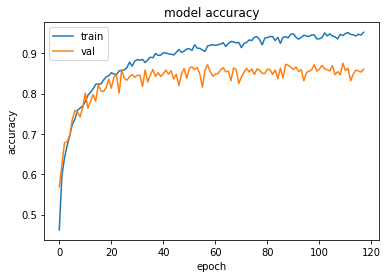

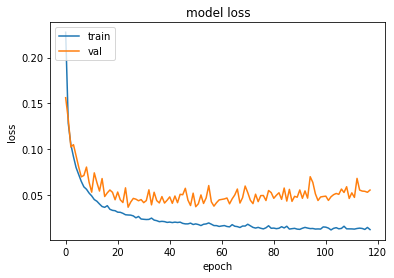

Number of positive predicted samples in the validation set:  460
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  460
F1 score for this fold is :  0.8798185941043084 0.9610850551400685
Training on fold 10/10...
Restoring model weights from the end of the best epoch
Epoch 00126: early stopping


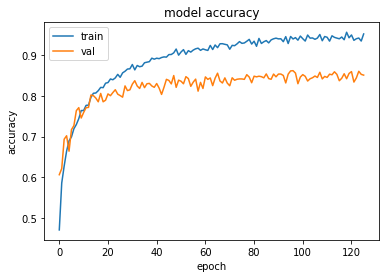

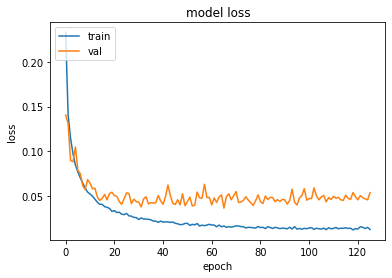

Number of positive predicted samples in the validation set:  478
100800/100800 [==============================] - 1s 6us/step
Number of positive predicted samples in the train set:  478
F1 score for this fold is :  0.8822222222222222 0.958775923115832


In [98]:
# Convert labels to categorical one-hot encoding
#train_labels_onehot = keras.utils.to_categorical(train_labels, num_classes=2)

mode_path = './models/mlp_v2.h5'

model = None
model = create_model()
model.summary()

best_fold = -1
best_score = 0
best_model = None

for index, (train_indices, val_indices) in enumerate(folds):

  print("Training on fold " + str(index+1) + "/10...")

  # Generate batches from indices
  xtrain, xval = train_seqs_onehot[train_indices], train_seqs_onehot[val_indices]
  #ytrain, yval = train_labels_onehot[train_indices], train_labels_onehot[val_indices]
  ytrain = np.array(train_labels)[train_indices.astype(int)]
  yval = np.array(train_labels)[val_indices.astype(int)]

  # xtrain_onehot = onehot_encoder.transform(xtrain)
  # xval_onehot = onehot_encoder.transform(xval)
  # ytrain_onehot = keras.utils.to_categorical(y_train, num_classes=2)
  # yval_onehot = keras.utils.to_categorical(y_val, num_classes=2)

  model = None
  model = create_model()

  # class wight for the train set
  class_weights = class_weight.compute_class_weight('balanced', np.unique(ytrain), ytrain)
  class_weight_dict = dict(enumerate(class_weights))

  # model.summary()
  with tf.device('/device:GPU:0'):
    callbacks = [ModelCheckpoint(filepath=mode_path, save_best_only=True),
                 EarlyStopping(monitor="val_get_f1", min_delta=0.01, patience=60, mode="max", baseline = 0.6,
                            restore_best_weights = True, verbose = 1)]

    history = model.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = NEPOCHS, batch_size=BATCHSIZE, verbose = 0,
              callbacks=callbacks, class_weight = class_weight_dict)  # starts training

  plot_loss_f1(history)

  # get the best fold based on the best f1 score
  y_pred = model.predict_classes(xval, batch_size=BATCHSIZE, verbose=0)
  print("Number of positive predicted samples in the validation set: ", np.sum(y_pred))

  y_train = model.predict_classes(xtrain, batch_size=BATCHSIZE, verbose=1)
  print("Number of positive predicted samples in the train set: ", np.sum(y_pred))

  y_pred_bool = y_pred.astype(int)
  tmp_score = metrics.f1_score(yval,y_pred)
  score_train = metrics.f1_score(ytrain,y_train)
  print("F1 score for this fold is : ", tmp_score, score_train)

  if(tmp_score > best_score):
    best_fold = index
    best_model = model
    model.save_weights('model.h5')


In [99]:
# train model on entire data set
# class wight for the train set
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weight_dict = dict(enumerate(class_weights))

# model.summary()
callbacks = [EarlyStopping(monitor="get_f1", min_delta=0.01, patience=80, mode="max", baseline = 0.6,
                            restore_best_weights = True, verbose = 1)]
model.load_weights('model.h5')
with tf.device('/device:GPU:0'):
  model.fit(train_seqs_onehot,train_labels, validation_split=0, epochs = NEPOCHS, batch_size=BATCHSIZE, verbose = 0 ,
            callbacks=callbacks, class_weight = class_weight_dict)  # starts training

Restoring model weights from the end of the best epoch
Epoch 00180: early stopping


In [100]:
# Training Error
y_pred = model.predict_classes(train_seqs_onehot, batch_size=BATCHSIZE, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(train_labels, y_pred))

112000/112000 [==============================] - 1s 6us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107787
           1       0.96      1.00      0.98      4213

    accuracy                           1.00    112000
   macro avg       0.98      1.00      0.99    112000
weighted avg       1.00      1.00      1.00    112000



#### Prediction on test data

In [101]:
y_pred = model.predict_classes(test_seqs_onehot, batch_size=BATCHSIZE,verbose = 1)
# res = np.argmax(y_pred, axis=1)
print(np.sum(y_pred))

# res = pd.DataFrame(res)
res = pd.DataFrame(y_pred)

48000/48000 [==============================] - 0s 6us/step
1939


#### Save results

In [0]:
res.to_csv("./prediction.csv", index=False, header=False)